In [2]:
import re
import numpy as np
import math
import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline
import sklearn.datasets
from sklearn import preprocessing, model_selection

/usr/local/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Data loading

In [3]:
# I use the code snippet from https://stackoverflow.com/questions/7368739/numpy-and-16-bit-pgm/7369986
# It read PGM image buffer string and return a numpy array
def read_pgm2(buffer, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.
    Format specification: http://netpbm.sourceforge.net/doc/pgm.html
    """
    #with open(filename, 'rb') as f:
    #    buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    #print 'width',width, 'height', height
    
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=15#len(header)
                            ).reshape((int(height), int(width)))

In [4]:
dataset0 = sklearn.datasets.load_files('/home/AD/lbreston/Data/CroppedYale', shuffle=True)

/home/AD/lbreston/Data/CroppedYale/yaleB19/yaleB19_P00A-035E-20.pgm
17
yaleB19
2304


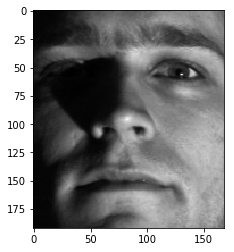

In [5]:
# Here is some sanity checks of the parsed dataset
idx0 = 10 #len(dataset0.filenames)-1
print(dataset0.filenames[idx0])
print(dataset0.target[idx0])
print(dataset0.target_names[dataset0.target[idx0]])
print(len(dataset0.filenames))
image0 = read_pgm2(dataset0.data[idx0])
plt.imshow(image0, plt.cm.gray)

In [6]:
# This cell includes the splittign of training and test set.
X = np.stack(map(read_pgm2, dataset0.data))
# X = X[:size0]

shapeX = X.shape
X = X.reshape((shapeX[0],shapeX[1]*shapeX[2]))
X = preprocessing.scale(X.astype(float),axis=1) # Mean removal and variance scaling

y_raw = dataset0.target
# idxs = [(y_raw == 0) | (y_raw == 1)|(y_raw == 2)|(y_raw == 3)|(y_raw == 4)|(y_raw == 5)]

# y_raw = y_raw[idxs]
# X = X[idxs]

enc = preprocessing.OneHotEncoder()
y = enc.fit_transform(y_raw.reshape(-1, 1)).toarray()
# y = y.reshape(-1)
# y = y[:size0]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.8, random_state=42, stratify=y)

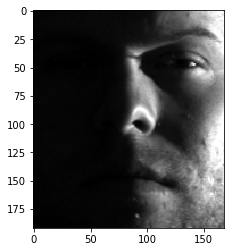

In [7]:
plt.imshow(X[y_raw==0][0].reshape(shapeX[1], shapeX[2]), plt.cm.gray)

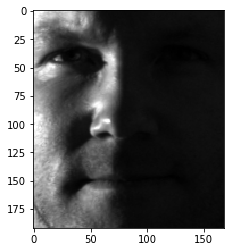

In [8]:
plt.imshow(X[y_raw==2][1].reshape(shapeX[1], shapeX[2]), plt.cm.gray)

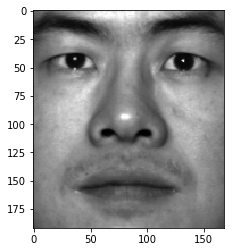

In [9]:
plt.imshow(X[y_raw==1][2].reshape(shapeX[1], shapeX[2]), plt.cm.gray)

In [10]:
_, train_counts = np.unique(np.argmax(y_train,1), return_counts=True)
train_max = np.argmax(train_counts)
print(train_counts)
print(train_max)

[ 3 10 12 11  8 17 15  7 14 11 15 11 16 13 18 12  9 13  7 13 13 15 14  7
 18 13 17 14 18 19 12 13 16 10 17  9]
29


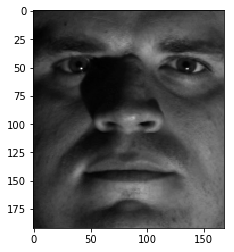

In [11]:
plt.imshow(X[y_raw==3][18].reshape(shapeX[1], shapeX[2]), plt.cm.gray)

In [12]:
baseline_acc = np.mean(np.argmax(y_test,1) == train_max)
baseline_acc

0.028741865509761388

# Optimal Encoding

In [13]:
from networks import MLP
from OptimalEncoding import OptimalEncoding

## Autoencoding

In [28]:
n_in = X.shape[-1]
k = 100
n_out = y.shape[-1]

sigma=5

widths = [300, 300]
depth = len(widths)

In [29]:
encoder = MLP(n_in, k, depth, widths)
decoder = MLP(k, n_out+1, depth, widths)

In [30]:
oe = OptimalEncoding(encoder, decoder, k)

In [ ]:
oe.train(X_train, y=y_train, min_entropy=True, epochs=5000, batch_size=20, lr=1e-3, sigma = sigma, task = 'classification', heteroskedastic = True)

  5%|▌         | 261/5000 [01:04<19:32,  4.04it/s]

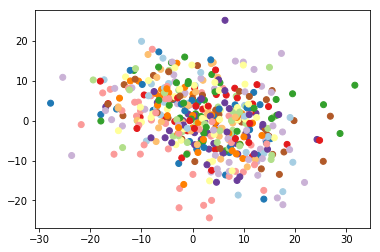

In [32]:
zhat_train = oe.encode(X_train, sigma=sigma)
plt.scatter(zhat_train[:,0], zhat_train[:,1], c = np.argmax(y_train,1), cmap=plt.get_cmap('Paired'))

In [33]:
pred_train = oe.decode(zhat_train)
pred_train = np.argmax(pred_train,1)

true_train = np.argmax(y_train,1)

acc_train = np.mean(pred_train == true_train)
print('train acc = %.3f' %acc_train)

train acc = 0.439


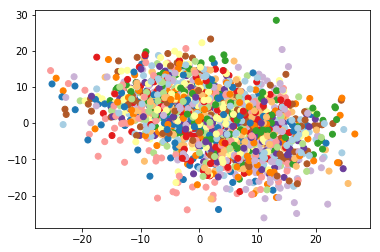

In [34]:
zhat_test = oe.encode(X_test, sigma=sigma)
plt.scatter(zhat_test[:,0], zhat_test[:,1], c = np.argmax(y_test,1), cmap=plt.get_cmap('Paired'))

In [35]:
pred_test = oe.decode(zhat_test)
pred_test = np.argmax(pred_test,1)

true_test = np.argmax(y_test,1)

acc_test = np.mean(pred_test == true_test)
print('test acc = %.3f' %acc_test)

test acc = 0.193


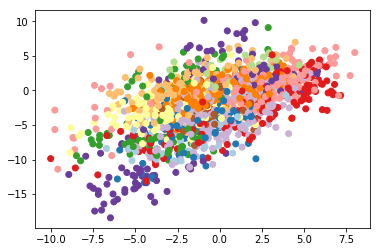

In [27]:
plt.scatter(zhat_test[:,0], zhat_test[:,1], c = pred_test, cmap=plt.get_cmap('Paired'))

In [22]:
1/float(y.shape[-1])

0.027777777777777776

# SubOptimal Encoding

In [23]:
n_in = X.shape[-1]
k = 100
n_out = y.shape[-1]

sigma = 1

widths = [300, 300]
depth = len(widths)

In [24]:
encoder = MLP(n_in, k, depth, widths)
decoder = MLP(k, n_out+1, depth, widths)

In [25]:
oe = OptimalEncoding(encoder, decoder, k)

In [ ]:
oe.train(X_train, y=y_train, min_entropy=False, epochs=5000, batch_size=100, lr=1e-3, sigma = sigma, task = 'classification',heteroskedastic = True)

  6%|▌         | 305/5000 [00:31<07:45, 10.08it/s]

In [ ]:
zhat_train = oe.encode(X_train, sigma=sigma)
plt.scatter(zhat_train[:,0], zhat_train[:,1], c = np.argmax(y_train,1), cmap=plt.get_cmap('Paired'))

In [ ]:
pred_train = oe.decode(zhat_train)
pred_train = np.argmax(pred_train,1)

true_train = np.argmax(y_train,1)

acc_train = np.mean(pred_train == true_train)
print('train acc = %.3f' %acc_train)

In [ ]:
zhat_test = oe.encode(X_test, sigma=sigma)
plt.scatter(zhat_test[:,0], zhat_test[:,1], c = np.argmax(y_test,1), cmap=plt.get_cmap('Paired'))

In [ ]:
pred_test = oe.decode(zhat_test)
pred_test = np.argmax(pred_test,1)

true_test = np.argmax(y_test,1)

acc_test = np.mean(pred_test == true_test)
print('test acc = %.3f' %acc_test)

In [ ]:
plt.scatter(zhat_test[:,0], zhat_test[:,1], c = pred_test, cmap=plt.get_cmap('Paired'))

In [ ]:
1/float(y.shape[-1])